# Problem understanding and overall proposed solution

Given a dataset of monthly metrics for a number of clients, predict whether they will apply or not to a credit line (loan).

The dataset contains two CSV files:
* customers.csv contains the monthly metric about each customer.
* credit_applications.csv contains whether they have applied for a credit on that month and how many times.

## Problem understanding

The problem is a classification problem where given a set of metrics $X $ one whishes to classify whether the customer will apply for a loan on the next month (i.e $y(c, m+1)$).

The training set will then contain $M=N_{customer}*N_{month}$ entries and for each entry will have N features (X is a matrix of M rows and N columns)

$$ X = {x(c, m) } = { [x_0(c, m), ..., x_N(c, m)] }  \forall c, m$$

To treat this problem as a classification problem one needs to forward the credit application into the future in order to create a consistent set of training data: at month m we know the data of $x(c, m)$ but we need to classify the future $y(c, m+1)$.

## Tech choice

Given the data size, memory manipulation is enough and the preferred weapon is based on the python machine learning ecosystem: ** pandas + scikit-learn + numpy + matplotlib + seaborn **


## Import datasets and basic transformations

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

df_clients = pd.read_csv('customers.csv', sep=';', index_col=0)
df_credits = pd.read_csv('credit_applications.csv', sep=';', index_col=0)
df = df_clients.merge(df_credits, on=['client_nr', 'yearmonth'])
del df_clients  # save memory, not needed anymore
del df_credits  # save memory, not needed anymore
df['yearmonth'] = df.yearmonth.apply(lambda x: dt.datetime.strptime(str(x), '%Y%m'))
df['month'] = df.yearmonth.apply(lambda x: x.month)
print("Total dataset shape = {}".format(df.shape))
df.tail()

Total dataset shape = (29996, 13)


,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,credit_application,nr_credit_applications,month
29991,1000,2016-04-01,2,1,605000,1,315800,131422,736422,NaN,0,0,4
29992,1000,2016-05-01,5,3,607506,2,1210000,128916,735145,NaN,0,0,5
29993,1000,2016-06-01,4,3,1211270,1,605000,127646,1338916,NaN,0,0,6
29994,1000,2016-07-01,4,2,606253,2,920000,441393,1047646,NaN,0,0,7
29995,1000,2016-08-01,3,1,1261,2,1210000,1045132,1650132,NaN,0,0,8


## Quick inspection of the dataset

* Do customer have big differences in volume or balance?
* Do customer have big differences in the changes of volume and balance?

A scatter plot for each pair of given features and how many times they applied for a credit is displayed and inspected. Spoiler alert: no magic feature is given (that would provide a great correlation/insight on the credit application). 

Also, one can see  highly correlated variables (e.g. nr_credit_trx, nr_total_trx) that provide little added value.

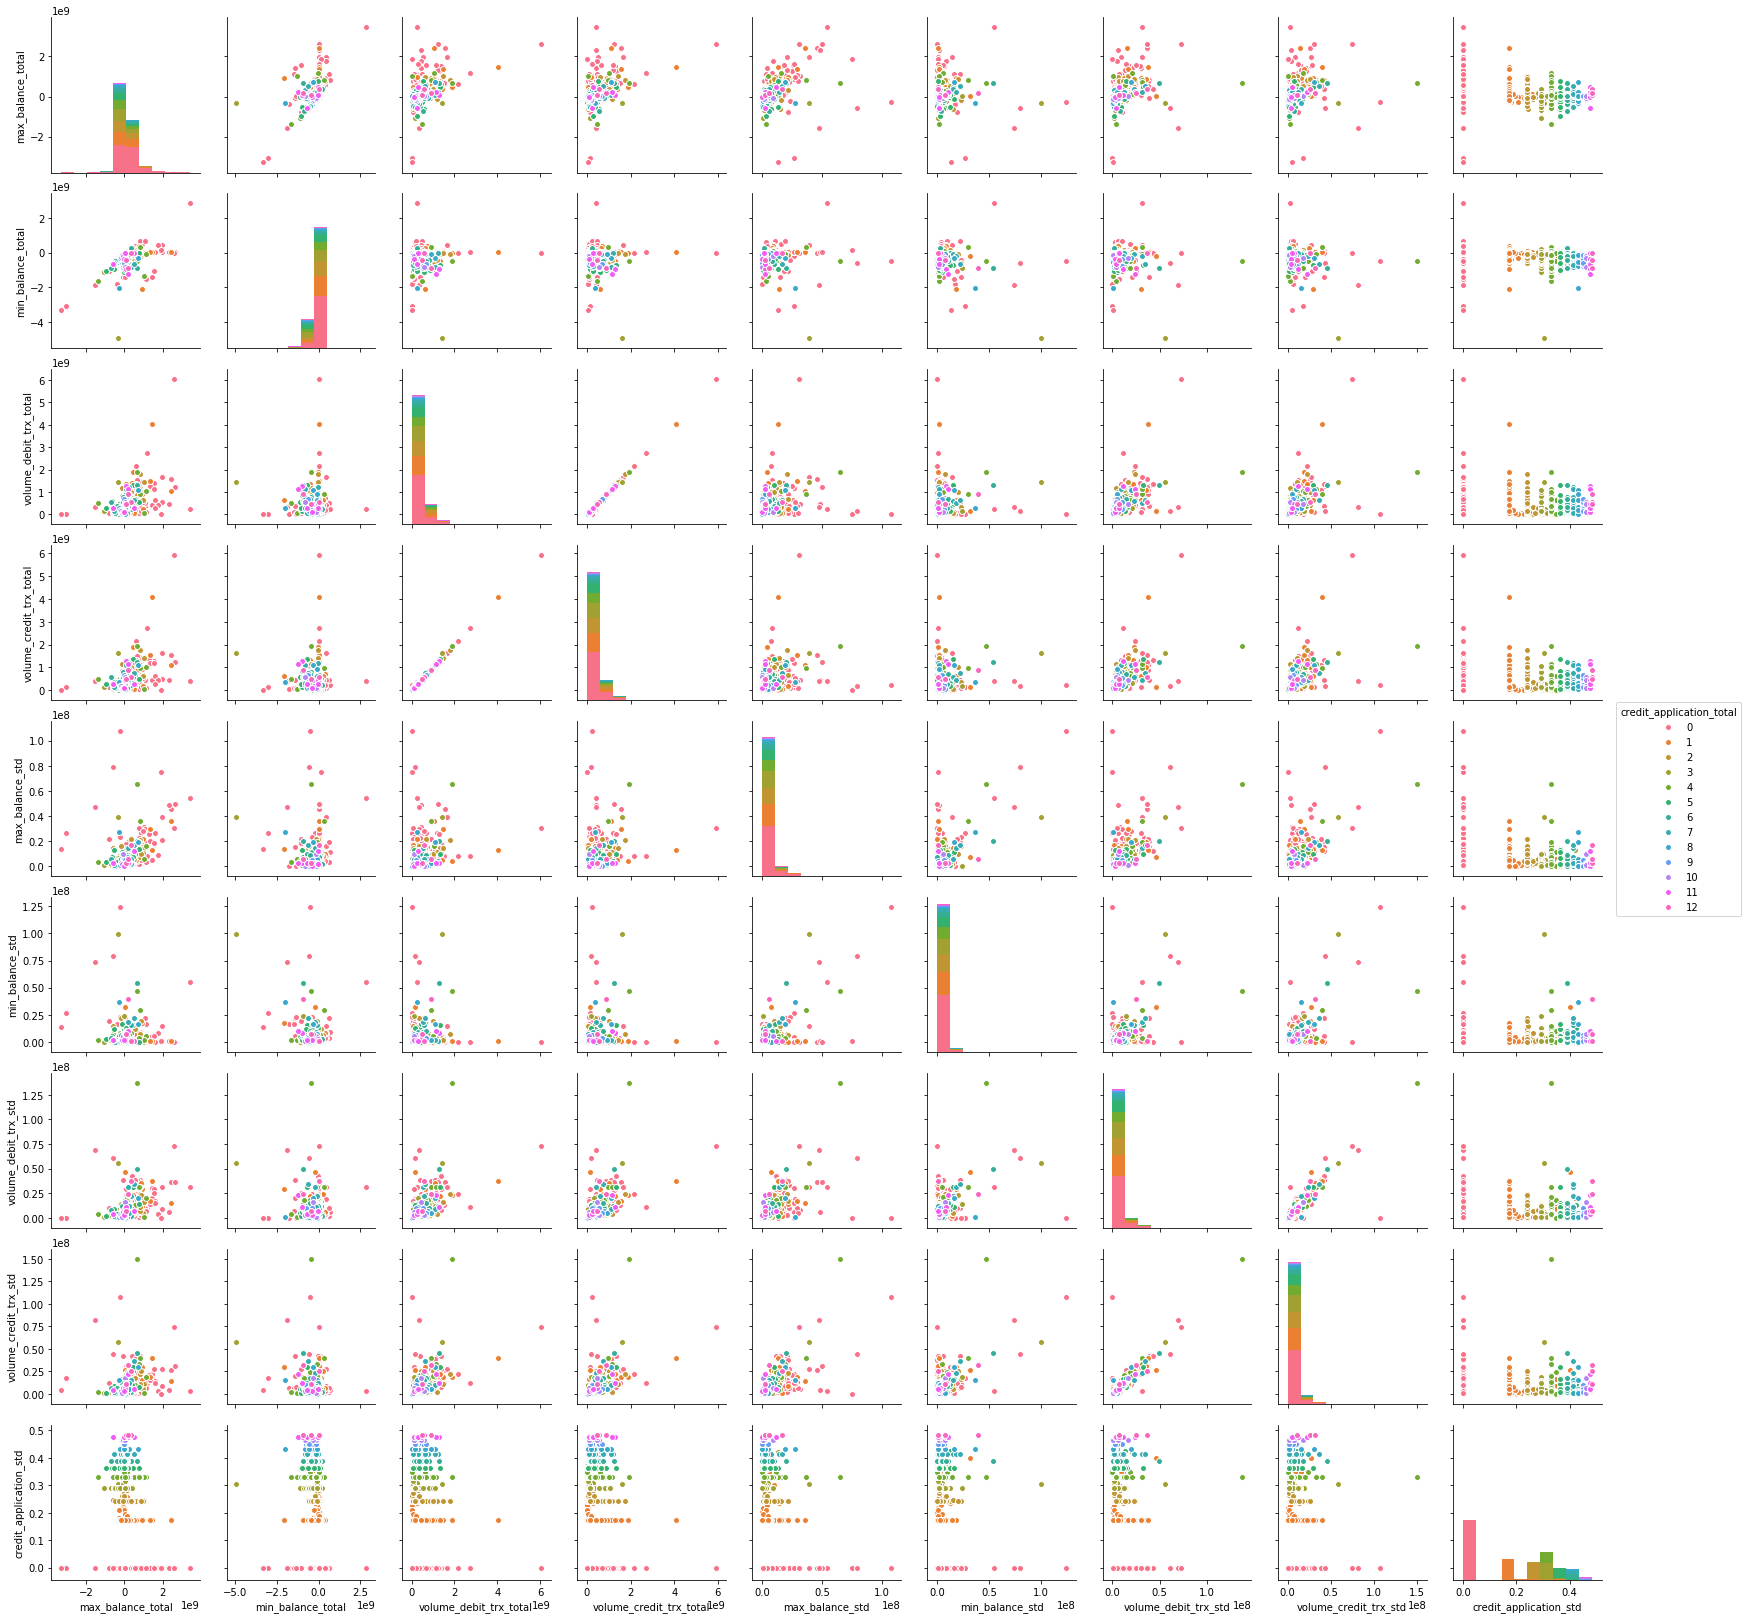

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def inspect(df, metrics, params, hue_is, save_plot=True):
    """
    Scatter plots of all features against chosen variable
    """
    agg_df = pd.DataFrame()
    for m, f in metrics.items():
        for p in params:
            agg_df[p+'_'+m] = df.groupby('client_nr')[p].apply(f)        
    sns.pairplot(agg_df, hue=hue_is, vars=[x for x in agg_df.columns if x != hue_is])
    if save_plot:
        plt.savefig('inspect.jpg')
    plt.show()

metrics = {'total':np.sum, 'std':np.std}
params = ['max_balance', 'min_balance', 'volume_debit_trx', 'volume_credit_trx', 'credit_application']
inspect(df, metrics, params, 'credit_application_total', save_plot=False)

## Feature engineering

In reality one should acquire relevant domain knowledge, either by teaming up with experts or researching, in order to be able to come up with good features (i.e. features or variables that would explain certain aspects of the classification or prediction).

The following metrics are computed that could help the decision:

* Total number of applications in the past
* Number of applications in the last 6 months or in the last 12 months.
* Average scaled balance difference over the last period (e.g. quarter), computed as :
$$ \mu_{\Delta B}(q) = {1 \over 3} \sum_{m \in q} {{B_{max}(m) - B_{min}(m)}  \over {\bar B_{max}}} $$

* STD of the scaled balance difference over the last period (e.g. quarter), computed as :
$$ \sigma_{\Delta B}(q) = STD({{B_{max}(m) - B_{min}(m)}  \over {\bar B_{max}}}) $$

* Average scaled volume difference over the last period (e.g. quarter), computed as :
$$ \mu_{\Delta V}(q) = {1 \over 3} \sum_{m \in q} {{V_{debit}(m) - V_{credit}(m)}  \over {\bar V_{debit}}} $$

* STD of the scaled balance difference over the last period (e.g. quarter), computed as :
$$ \sigma_{\Delta V}(q) = STD({{V_{debit}(m) - V_{credit}(m)}  \over {\bar V_{debit}}}) $$

* Average CRG from the last 6 months

* Accumulated credit since last credit_application

* Regularity when applying for credits

The fact that the metrics are scaled is to consider that some customers work in the 10 MEUR scales and other are operating on the 1000MEUR scales, which is orders of magnitude different.

** Important **: also, the variable to predict should be shifted into the future 1 month: we can use up to month M-1 to predict month M. But this should be done at the very last step if one does not want to mix the future information with the feature building process. This is done with the class method `forward_feature()`

In [3]:
class FeatureBuilder():
    """
    Class that allows elegant manipulation of features
    """
    def __init__(self, df):
        self.data = pd.pivot_table(df, index=['yearmonth'], columns=['client_nr'])
    
    def add_feature(self, new_feature, name):
        new_feature.columns = pd.MultiIndex.from_product([[name], new_feature.columns])
        self.data = pd.concat([self.data, new_feature], axis=1)
       
    def __getitem__(self, i):
        return self.data[i]
    
    def forward_feature(self, name, drop_last=True):
        self.data.loc(axis=1)[name, :] = self.data.loc(axis=1)[name, :].shift(-1)
        if drop_last:
            self.data.drop(self.data.index.max(), axis=0, inplace=True) 
            
    def to_df(self):
        df = self.data.stack().reset_index()
        print("Total dataset shape = {}".format(df.shape))
        return df
    
fb = FeatureBuilder(df)

# Number of applications so far
foo = fb['credit_application'].fillna(0).cumsum()
fb.add_feature(foo, 'past_credit_applications')

foo = fb['credit_application'].fillna(0).rolling(6).sum()
fb.add_feature(foo, 'credit_application_last6m')

foo = fb['credit_application'].fillna(0).rolling(12).sum()
fb.add_feature(foo, 'credit_application_last12m')

# Balance differences rolling
scale = fb['max_balance'].mean()
foo = ((fb['max_balance'] - fb['min_balance'])/scale).fillna(0).rolling(6).mean()
fb.add_feature(foo, 'balance_diff_avg')
foo = ((fb['max_balance'] - fb['min_balance'])/scale).fillna(0).rolling(6).std()
fb.add_feature(foo, 'balance_diff_std')

# Volume differences rolling
scale = fb['volume_debit_trx'].mean()
foo = ((fb['volume_debit_trx'] - fb['volume_credit_trx'])/scale).fillna(0).rolling(6).mean()
fb.add_feature(foo, 'volume_diff_avg')
foo = ((fb['volume_debit_trx'] - fb['volume_credit_trx'])/scale).fillna(0).rolling(6).std()
fb.add_feature(foo, 'volume_diff_std')

# Average CRG from the last 6 months
foo = fb['CRG'].fillna(0).rolling(6).mean()
fb.add_feature(foo, 'avg_CRG')

# Credit since last application
def roll(x, i):  # recursively iterate arrays
    if i == 0:
        return x[i]
    if x[i] == 0:
        return roll(x, i-1)
    return x[i]

def roll_all(x):
    return [roll(x, i) for i in range(len(x))]

foo = (fb['volume_credit_trx'].cumsum() * fb['credit_application'])
foo = fb['volume_credit_trx'].cumsum() - foo.apply(roll_all)
fb.add_feature(foo, 'volume_credit_since_last_application')

foo = (fb['min_balance'].cumsum() * fb['credit_application'])
foo = fb['min_balance'].cumsum() - foo.apply(roll_all)
fb.add_feature(foo, 'min_balance_since_last_application')

foo = (fb['nr_credit_trx'].cumsum() * fb['credit_application'])
foo = fb['nr_credit_trx'].cumsum() - foo.apply(roll_all)
fb.add_feature(foo, 'nr_credit_trx_since_last_application')

# Shift credit application into the future
# That must be the very last step in order not to give info from the future
fb.forward_feature(name='credit_application', drop_last=True)


df = fb.to_df()
df.tail()

Total dataset shape = (30752, 24)


,yearmonth,client_nr,CRG,avg_CRG,balance_diff_avg,balance_diff_std,credit_application,credit_application_last12m,credit_application_last6m,max_balance,...,nr_credit_trx,nr_credit_trx_since_last_application,nr_debit_trx,past_credit_applications,total_nr_trx,volume_credit_since_last_application,volume_credit_trx,volume_debit_trx,volume_diff_avg,volume_diff_std
30747,2016-07-01,996,NaN,NaN,-0.474545,1.162394,NaN,0.0,0.0,0.0,...,1.0,NaN,1.0,0.0,2.0,NaN,783.0,233.0,0.000000,0.888507
30748,2016-07-01,997,NaN,NaN,0.336219,0.525833,0.0,0.0,0.0,1969077.0,...,33.0,NaN,26.0,0.0,59.0,NaN,2288335.0,2239978.0,-0.005932,0.009211
30749,2016-07-01,998,NaN,NaN,0.248692,0.608781,0.0,0.0,0.0,1033231.0,...,27.0,NaN,15.0,0.0,42.0,NaN,2019716.0,1469000.0,-0.067808,0.166293
30750,2016-07-01,999,NaN,NaN,0.401166,0.252406,0.0,0.0,0.0,21667760.0,...,46.0,893.0,26.0,0.0,72.0,213203627.0,15992072.0,13102415.0,0.002329,0.568240
30751,2016-07-01,1000,NaN,NaN,0.903211,0.329673,0.0,0.0,0.0,1047646.0,...,2.0,NaN,2.0,0.0,4.0,NaN,920000.0,606253.0,0.057485,0.563238


Most importantly we want to understand how much of the prediction we can explain with the available features, a heatmap is provided and a zoom on the prediction variable is also given.

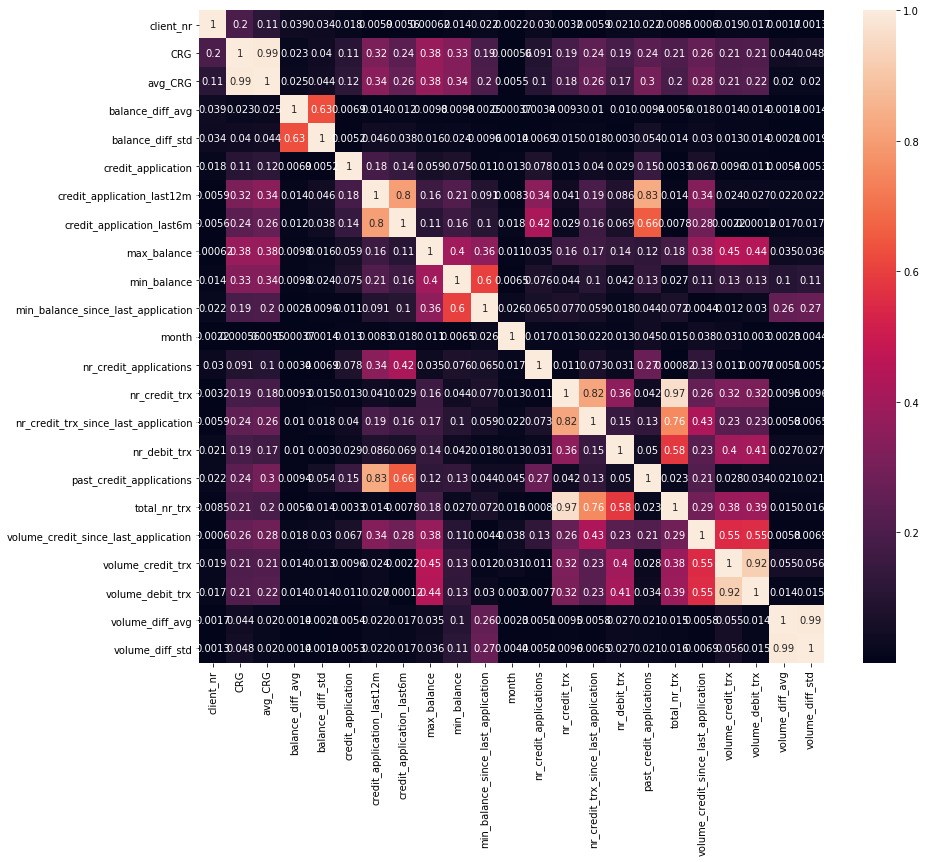

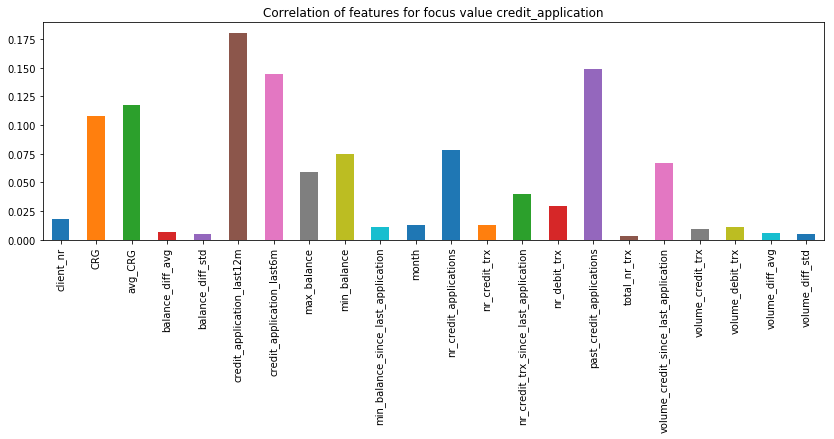

In [4]:
# Correlations
corr_df = abs(df.corr())
plt.figure(figsize=(14,12))
sns.heatmap(corr_df, annot=True)
plt.show()

c = 'credit_application'
corr_df.loc[c, [x for x in corr_df.columns if x != c]].plot(kind='bar', figsize=(14,4))
plt.title('Correlation of features for focus value {}'.format(c))
plt.show()

# Predictions

## Configuration of the predictions

The following parameters drive the configuration of the predictions.

In [5]:
# configuration
exclude = ['yearmonth', 'credit_application']
corr_th = 0.001  # only use features that have at least that correlation
predict_what = 'credit_application'
on_future = True  # train-test split is based on past-future and not randomly
scale = False  # whether to scale the features so they all are in a similar interval (-1, 1)
use_nan = True # for missing data, sets the feature to zero as default (something more clever could be done)

## Module support functions

The following functions would typically go on a module but are left in the notebook for clarity.

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

def exclude_threshold(corr_vec, exclude, threshold=0.1):
    """Returns features over a correlation threshold plus excluded ones"""
    return list(corr_vec[corr_vec < threshold].index) + exclude

get_x = lambda df: df[[x for x in df.columns if x not in exclude_threshold(corr_df[predict_what], exclude, corr_th)]]
get_y = lambda df: df[predict_what].astype(bool).astype(int)

def train_test_split_date(df, date):
    """ 
    Splits based on the past (train) and the future (test) of date. 
    Closest to real business life
    """
    return df[df.yearmonth <= date], df[df.yearmonth > date]

def pretty_confusion_matrix(true_y, pred_y):
    """
    Provides the confusion matrix with printed axis
    """
    if type(pred_y[0]) != bool or type(pred_y[0]) != int:
        pred_y = np.round(pred_y).astype(int)
    pcf = pd.DataFrame(columns=pd.MultiIndex.from_product([['Predicted'], [False, True]]), 
                       index=pd.MultiIndex.from_product([['Actual'], [False, True]]), 
                       data=confusion_matrix(true_y, pred_y))
    return pcf
    
def benchmark(clf, what='train'):
    which_data = train_data if what == 'train' else test_data
    predict_y = clf.predict(get_x(which_data))
    print(pretty_confusion_matrix(get_y(which_data), predict_y))

def fit_benchmark(clf, **kwargs):
    """
    Uses scope train_data and test_data to fit and benchmark
    """
    # classifier will be updated in reference area, so it is available afterwards
    clf.fit(get_x(train_data), get_y(train_data), **kwargs)
    print("Model performance on train dataset")
    benchmark(clf, what='train')
    print("Model performance on test dataset")
    benchmark(clf, what='test')

## Data pre-processing and train-test split

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

if use_nan:
    df.fillna(0, inplace=True)  # CRG and credit_applications not available on certain records, set to 0.
else:
    df.dropna(inplace=True)
    
if scale:
    scaler = StandardScaler()
    scaler.fit(get_x(df))
    df.loc[get_x(df).index, get_x(df).columns] = scaler.transform(get_x(df))

if on_future:
    train_data, test_data = train_test_split_date(df, dt.datetime(2016, 3, 1))
else:
    train_data, test_data = train_test_split(df, train_size=0.8)
    
print("Train data size = {}".format(train_data.shape))
print("Test data size = {}".format(test_data.shape))

Train data size = (26784, 24)
Test data size = (3968, 24)


## Prediction

Given the nature of the problem, a confusion matrix is the best metric to understand what is going on:

* Actual=0, Predicted=0: this is a True Negative (TN). This basically means that we have predicted that this customer over that month is not interesting and it wasn't.
* Actual=1, Predicted=1: this is a True Positive (TP). This basically means that we have predicted that this customer over that month would ask for a loan and it did.
* Actual=1, Predicted=0: this is a False Negative (FN). This basically means that we have predicted that this customer over that month is not interesting but it actually asked for a loan.
* Actual=0, Predicted=1: this is a False Positive (FP). This basically means that we have predicted that this customer over that month would ask for a loan and it didn't.

Moreover in this case, the recall (the capacity to not miss people asking for a loan) is a more interesting score rather than precision (the art of not engaging a customer when it is not interested) as there is more business loss in the former.

### Support Vector Machine

When using a SVM we see that we almost fit the training set (precision and recall ~1) but we fail miserably at predicting the new dataset since we basically classify everything as 0. 
This is an example of overfitting that could be helped by using regularization or by using a different classifier that is less prone to overfitting.

In [8]:
from sklearn.svm import SVC

clf = SVC(C=1)
fit_benchmark(clf)

Model performance on train dataset
             Predicted      
                 False True 
Actual False     25035     0
       True          2  1747
Model performance on test dataset
             Predicted      
                 False True 
Actual False      3749     0
       True        219     0


### Random forests

In [9]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
fit_benchmark(clf)

Model performance on train dataset
             Predicted      
                 False True 
Actual False     25035     0
       True        353  1396
Model performance on test dataset
             Predicted      
                 False True 
Actual False      3733    16
       True        216     3


Next we will use a Random Forest classifier but we will perform a Grid Search over hyperparameters to maximize recall. This is an expensive calculation as we will iterate over all the permutations of hyperparameters in the input dictionaries but allows for an automated search of the best solution.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, make_scorer

clf = RandomForestClassifier()
gs = GridSearchCV(clf, 
                  {'max_features':list(range(5,len(get_x(df).columns))), 
                   'min_samples_split':[2,3,4, 5, 6]},
                  scoring=make_scorer(recall_score))
fit_benchmark(gs)
print("Best score is: {} with estimator".format(gs.best_score_))
gs.best_estimator_

Model performance on train dataset
             Predicted      
                 False True 
Actual False     25034     1
       True        354  1395
Model performance on test dataset
             Predicted      
                 False True 
Actual False      3719    30
       True        211     8
Best score is: 0.11092052601486563 with estimator


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=20, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Neural network classification

Trying out a NN for classification results (even with grid-searching the regularization parameter) in an absolute 0 recall, for that given architecture.

In [11]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier (hidden_layer_sizes=[10, 24], alpha=1)
gs = GridSearchCV(clf, 
                  {'alpha':[1e-4, 1e-2, 1, 10, 100]}, 
                  scoring=make_scorer(recall_score))
fit_benchmark(gs)
print("Best score is: {} with estimator".format(gs.best_score_))
gs.best_estimator_

Model performance on train dataset
             Predicted      
                 False True 
Actual False     23630  1405
       True       1641   108
Model performance on test dataset
             Predicted      
                 False True 
Actual False      3548   201
       True        207    12
Best score is: 0.21841052029731273 with estimator


MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[10, 24], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

# TODO: next steps

Basically there were two limiting factors on my analysis:
* 1) Lack of business knowledge
* 2) Time

If possible I would then follow this roadmap to come up with a good predictive model.

* Talk to the business people to understand what makes a certain customer go for a loan and model that in the features.
* Pre-process the customer pool into clusters based on different features (e.g. size, regularity...) and then train a model for each cluster.
* Come up with a good policy for missing data, for example, discarding or interpolating over the gaps.
* Use polynomial features.
* Explode the datasize (more months or more customers, or both) and prevent overfitting by just throwing loads of data to a complex model. For this maybe another framework would be needed such as Apache-Spark.
* Predict not only the likelihood of classification but also the number of times someone might ask for a loan every month.
* Make the prediction lighter by using PCA or another dimensionality reduction technique